In [5]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
from __future__ import print_function
import json
import time
import datetime

# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    states="""AK"""
    networks = []
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations


def download_alldata():
    """An alternative method that fetches all available data.
    Service supports up to 24 hours worth of data at a time."""
    # timestamps in UTC to request data for
    startts = datetime.datetime(2012, 8, 1)
    endts = datetime.datetime(2012, 9, 1)
    interval = datetime.timedelta(hours=24)

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    now = startts
    while now < endts:
        thisurl = service
        thisurl += now.strftime("year1=%Y&month1=%m&day1=%d&")
        thisurl += (now + interval).strftime("year2=%Y&month2=%m&day2=%d&")
        print("Downloading: %s" % (now,))
        data = download_data(thisurl)
        outfn = "%s.txt" % (now.strftime("%Y%m%d"),)
        with open(outfn, "w") as fh:
            fh.write(data)
        now += interval


def main():
    """Our main method"""
    # timestamps in UTC to request data for
    startts = datetime.datetime(2012, 8, 1)
    endts = datetime.datetime(2012, 9, 1)

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    stations = get_stations_from_networks()
    # stations = get_stations_from_filelist("mystations.txt")
    for station in stations:
        uri = "%s&station=%s" % (service, station)
        print("Downloading: %s" % (station,))
        data = download_data(uri)
        outfn = "%s_%s_%s.txt" % (
            station,
            startts.strftime("%Y%m%d%H%M"),
            endts.strftime("%Y%m%d%H%M"),
        )
        out = open(outfn, "w")
        out.write(data)
        out.close()

def get_stations_details_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    networks = []
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append([site["properties"]["sname"], site["properties"]["sid"], site["properties"]["state"], 
                             site["properties"]["county"], site["geometry"]["coordinates"][0],
                             site["geometry"]["coordinates"][1]])
    return stations
        
    

In [6]:
data = get_stations_details_from_networks()

In [7]:
import pandas as pd
df = pd.DataFrame(data, columns=['Name', 'Station', 'State', 'County', 'Long', 'Lat'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Name     2817 non-null   object 
 1   Station  2817 non-null   object 
 2   State    2817 non-null   object 
 3   County   2817 non-null   object 
 4   Long     2817 non-null   float64
 5   Lat      2817 non-null   float64
dtypes: float64(2), object(4)
memory usage: 132.2+ KB


In [51]:
df.to_csv('station_locations.csv')

In [9]:
df.head()

,Name,Station,State,County,Long,Lat
0,ADAK NAS/MITCHELL,PADK,AK,Aleutians West,-176.6460,51.8780
1,AKHIOK,PAKH,AK,Lake & Peninsula,-154.1800,56.9400
2,Akun,PAUT,AK,Aleutians East,-165.6041,54.1446
3,Alpine,PALP,AK,North Slope,-150.9447,70.3443
4,AMBLER,PAFM,AK,Northwest Arctic,-157.8575,67.1063


In [22]:
airport_data = pd.read_csv("airports.csv")

In [23]:
airport_data.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [55]:
atlanta_data = airport_data[airport_data["DISPLAY_AIRPORT_NAME"]=="Atlanta Municipal"]

In [20]:
from math import radians, cos, sin, asin, sqrt
def cal_distance(lat1, lat2, lon1, lon2):
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    # calculate the result
    return(c * r)

In [57]:
distance_from_atl = []
for item, row in df.iterrows():
    distance_from_atl.append(cal_distance(row["Lat"], atlanta_data["LATITUDE"], row["Long"], atlanta_data["LONGITUDE"]))
df["atl_dist"] = distance_from_atl

In [64]:
df.sort_values(by="atl_dist")[0:10]

,Name,Station,State,County,Long,Lat,atl_dist
687,ATLANTA INTL ARPT,ATL,GA,Fulton,-84.4418,33.6301,1.801614
686,ATLANTA/FULTON CO.,FTY,GA,Cobb,-84.5200,33.7800,17.694925
685,ATLANTA/DEKALB,PDK,GA,De Kalb,-84.3020,33.8756,28.556522
726,Hampton,HMP,GA,Henry,-84.3310,33.3899,29.293779
727,Hampton,4A7,GA,Henry,-84.3324,33.3891,29.339386
713,DOBBINS AFB/MARIETT,MGE,GA,Cobb,-84.5163,33.9153,31.610281
750,PEACHTREE CITY,FFC,GA,Coweta,-84.5669,33.3553,34.289948
740,MARIETTA,RYY,GA,Cobb,-84.5986,34.0131,44.317948
757,Spalding,6A2,GA,Spalding,-84.2749,33.2270,48.138080
749,NEWNAN COWETA COUNTY AIRPORT,CCO,GA,Coweta,-84.7700,33.3100,48.621510


In [15]:
airport_data[airport_data['AIRPORT_STATE_CODE']=='GA'].head()

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_WAC,AIRPORT_COUNTRY_NAME,AIRPORT_COUNTRY_CODE_ISO,AIRPORT_STATE_NAME,AIRPORT_STATE_CODE,AIRPORT_STATE_FIPS,...,LON_DEGREES,LON_HEMISPHERE,LON_MINUTES,LON_SECONDS,LONGITUDE,AIRPORT_START_DATE,AIRPORT_THRU_DATE,AIRPORT_IS_CLOSED,AIRPORT_IS_LATEST,Unnamed: 27
230,10146,ABY,Southwest Georgia Regional,"Albany, GA",34,United States,US,Georgia,GA,13.0,...,84.0,W,11.0,46.0,-84.196111,1950-01-01,2011-06-30,0,0,NaN
231,10146,ABY,Southwest Georgia Regional,"Albany, GA",34,United States,US,Georgia,GA,13.0,...,84.0,W,11.0,40.0,-84.194444,2011-07-01,NaN,0,1,NaN
424,10208,AGS,Bush Field,"Augusta, GA",34,United States,US,Georgia,GA,13.0,...,81.0,W,57.0,52.0,-81.964444,1950-01-01,2000-06-30,0,0,NaN
425,10208,AGS,Augusta Regional at Bush Field,"Augusta, GA",34,United States,US,Georgia,GA,13.0,...,81.0,W,57.0,52.0,-81.964444,2000-07-01,2011-06-30,0,0,NaN
426,10208,AGS,Augusta Regional at Bush Field,"Augusta, GA",34,United States,US,Georgia,GA,13.0,...,81.0,W,57.0,52.0,-81.964444,2011-07-01,NaN,0,1,NaN


In [17]:
airport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18101 entries, 0 to 18100
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AIRPORT_ID                      18101 non-null  int64  
 1   AIRPORT                         18101 non-null  object 
 2   DISPLAY_AIRPORT_NAME            18101 non-null  object 
 3   DISPLAY_AIRPORT_CITY_NAME_FULL  18101 non-null  object 
 4   AIRPORT_WAC                     18101 non-null  int64  
 5   AIRPORT_COUNTRY_NAME            18101 non-null  object 
 6   AIRPORT_COUNTRY_CODE_ISO        18011 non-null  object 
 7   AIRPORT_STATE_NAME              7811 non-null   object 
 8   AIRPORT_STATE_CODE              7811 non-null   object 
 9   AIRPORT_STATE_FIPS              6930 non-null   float64
 10  CITY_MARKET_ID                  18101 non-null  int64  
 11  DISPLAY_CITY_MARKET_NAME_FULL   18101 non-null  object 
 12  CITY_MARKET_WAC                 

In [24]:
graph_df = pd.DataFrame()
graph_df_list = []
for item, row in df.iterrows():
    for i,r in airport_data.iterrows():
        graph_df_list.append([row['Name'],row['Station'],row['State'],r['airport'],r['state'],cal_distance(row["Lat"], r["lat"], row["Long"], r["long"])])

In [25]:
graph_df = pd.DataFrame(graph_df_list, columns=['Station_Name','Station_Code','Station_State','Airport','Airport_State','Distance'])

In [3]:

graph_df.to_csv('Bipartite_network_data.csv')

NameError: name 'graph_df' is not defined

In [9]:
import pandas as pd
airport_data = pd.read_csv("airports.csv")
graph_df = pd.read_csv('Bipartite_network_data.csv')
df = pd.read_csv('station_locations.csv')

In [10]:
import networkx as nx

bg = nx.Graph()

bg.add_nodes_from(airport_data['airport'].unique(), bipartite=0, pos=())
bg.add_nodes_from(df['Station'].unique(), bipartite=1)

for item,row in graph_df.iterrows():
    bg.add_edge(row["Station_Code"], row["Airport"], weight=row["Distance"])



In [11]:
sorted_bg = sorted(bg.edges('William B Hartsfield-Atlanta Intl'), key = lambda x: bg.get_edge_data(x[0], x[1])["weight"])


In [33]:
import numpy as np
sub_graph = nx.Graph()
#airports = airport_data[airport_data["state"]=="GA"]["airport"].unique()[:3]
#airports = np.append('William B Hartsfield-Atlanta Intl', airports)
airports = ['Athens Municipal','William B Hartsfield-Atlanta Intl','Middle Georgia Regional']
for airport in airports:
    sub_graph.add_node(airport, color='lightskyblue', node_size=300, pos=(airport_data[airport_data["airport"]==airport].iloc[0]['lat'], airport_data[airport_data["airport"]==airport].iloc[0]['long']))
    sorted_bg = sorted(bg.edges(airport), key = lambda x: bg.get_edge_data(x[0], x[1])["weight"])[1:]
    for i in range(0,20):
        sub_graph.add_node(sorted_bg[i][1], color="orange", node_size=100, pos=(df[df["Station"]==sorted_bg[i][1]].iloc[0]['Lat'],df[df["Station"]==sorted_bg[i][1]].iloc[0]['Long']))
        sub_graph.add_edge(airport, sorted_bg[i][1])

In [34]:
pos = nx.get_node_attributes(sub_graph,'pos')
color = nx.get_node_attributes(sub_graph,'color')
node_sizes = nx.get_node_attributes(sub_graph, 'node_size')

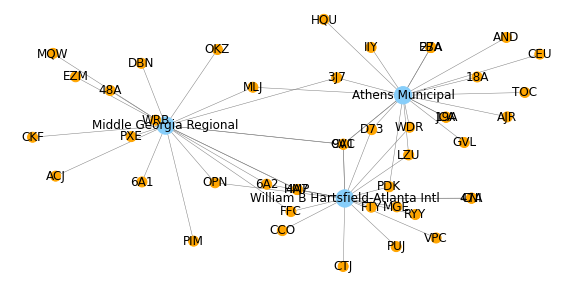

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
nx.draw(sub_graph,pos, node_size= list(node_sizes.values()), node_color = color.values(), width = 0.5, edge_color = 'gray', with_labels=True)
plt.savefig(r'/Users/manojprabhakarpaidiparthy/Documents/MS/bi_network.pdf', format='pdf', bbox_inches='tight', dpi=300)


In [30]:
print(list(node_sizes.values()))

[300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
